In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers torch datasets scikit-learn pandas imblearn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 818.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df = pd.read_csv("/content/drive/MyDrive/DSGP/dataset/intents_more.csv", encoding='latin-1')

In [21]:
df = df[["intent", "examples"]]
df.dropna(inplace=True)

In [22]:
df.shape

(982, 2)

In [23]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
print("Dataset Sample:")
print(df.head())

Dataset Sample:
                 intent                                    examples
0  feedback_suggestions    You should add a birdwatching checklist.
1  feedback_suggestions  Id love to see more interactive features.
2          user_opinion              Birds are a symbol of freedom.
3     feedback_positive                   I love learning from you!
4  greet_good_afternoon                  Afternoon bot, lets chat!


<ipython-input-25-6bbd7187fb7c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")


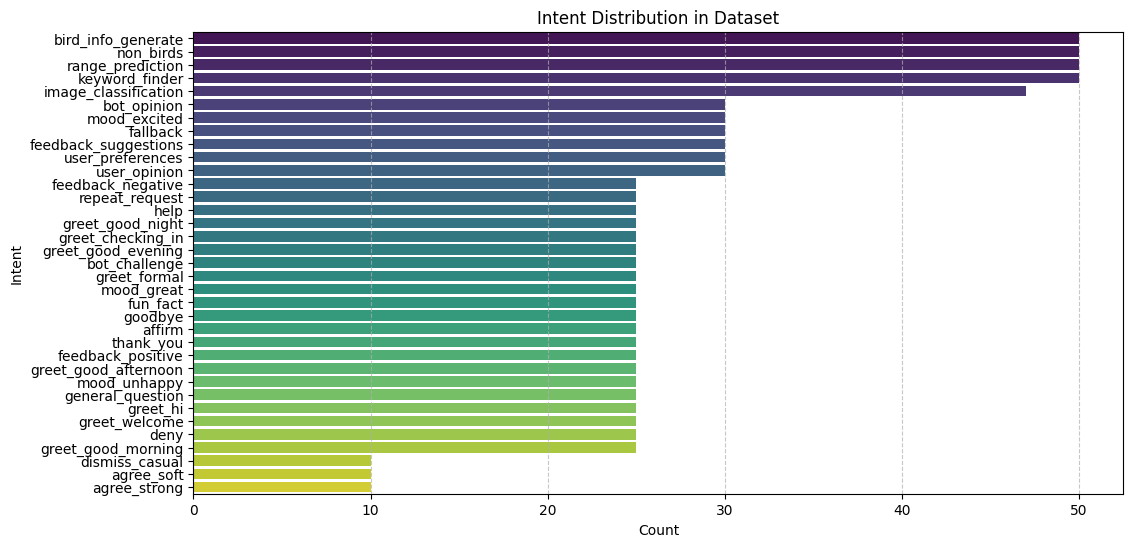

In [25]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.countplot(y=df["intent"], order=df["intent"].value_counts().index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Intent")
plt.title("Intent Distribution in Dataset")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Convert intents into numerical values

In [26]:
label_encoder = LabelEncoder()
df["intent"] = label_encoder.fit_transform(df["intent"])

### Label Mapping

In [28]:
# Store Label Mapping for Future Use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'affirm': 0, 'agree_soft': 1, 'agree_strong': 2, 'bird_info_generate': 3, 'bot_challenge': 4, 'bot_opinion': 5, 'deny': 6, 'dismiss_casual': 7, 'fallback': 8, 'feedback_negative': 9, 'feedback_positive': 10, 'feedback_suggestions': 11, 'fun_fact': 12, 'general_question': 13, 'goodbye': 14, 'greet_checking_in': 15, 'greet_formal': 16, 'greet_good_afternoon': 17, 'greet_good_evening': 18, 'greet_good_morning': 19, 'greet_good_night': 20, 'greet_hi': 21, 'greet_welcome': 22, 'help': 23, 'image_classification': 24, 'keyword_finder': 25, 'mood_excited': 26, 'mood_great': 27, 'mood_unhappy': 28, 'non_birds': 29, 'range_prediction': 30, 'repeat_request': 31, 'thank_you': 32, 'user_opinion': 33, 'user_preferences': 34}


## Random Oversampling

In [36]:
X = df["examples"]
y = df["intent"]

oversample = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)

In [37]:
df_balanced = pd.DataFrame({"examples": X_resampled.flatten(), "intent": y_resampled})
print("Balanced Class Distribution:\n", df_balanced["intent"].value_counts())

Balanced Class Distribution:
 intent
12    50
15    50
20    50
27    50
16    50
7     50
4     50
18    50
1     50
14    50
23    50
29    50
9     50
26    50
2     50
31    50
25    50
3     50
34    50
13    50
11    50
6     50
24    50
5     50
22    50
21    50
28    50
30    50
33    50
17    50
10    50
8     50
32    50
0     50
19    50
Name: count, dtype: int64


<ipython-input-43-93613f1d5354>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts_after.index, y=intent_counts_after.values, ax=axes[1], palette="coolwarm")


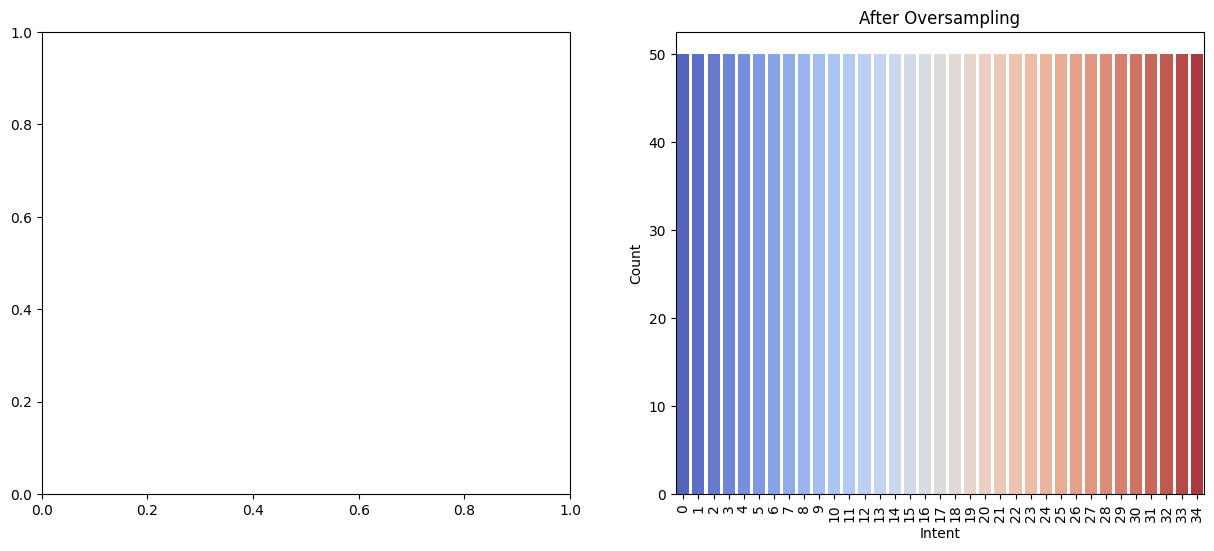

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=intent_counts_after.index, y=intent_counts_after.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("After Oversampling")
axes[1].set_xlabel("Intent")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)

plt.show()

## Dataset Preprocessing

In [44]:
stop_words = set(stopwords.words("english"))

In [46]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [47]:
# Apply text preprocessing
df_balanced["examples"] = df_balanced["examples"].apply(preprocess_text)

print("Text Preprocessing Complete!")
print(df_balanced.head())

Text Preprocessing Complete!
                           examples  intent
0              tell crazy bird fact      12
1    prefer information small birds      34
2          history birds would nice      11
3                                         6
4  find bird species uploaded image      24


## Split Dataset

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["examples"], df_balanced["intent"], test_size=0.2, random_state=42
)

### Load BERT Tokenizer

In [49]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Create Dataset Objects

In [50]:
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert Intent Labels to Numeric
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# Create Dataset Objects
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


## Build BERT model

In [51]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_mapping)
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [53]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=1
    )
    acc = accuracy_score(labels, preds)

    print(f"Train Accuracy: {acc}")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harindu-20230712 (harindu-20230712-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.541900,3.436483,0.062857,0.022971,0.697880,0.062857
2,3.160300,3.113060,0.260000,0.196923,0.610717,0.260000
3,2.493600,2.425601,0.522857,0.487435,0.631170,0.522857
4,1.690300,1.608649,0.711429,0.697932,0.763362,0.711429
5,1.009700,0.952100,0.840000,0.837369,0.858509,0.840000
6,0.606400,0.704643,0.845714,0.848113,0.881479,0.845714
7,0.247200,0.525289,0.885714,0.885829,0.897315,0.885714
8,0.194700,0.546030,0.874286,0.874817,0.892645,0.874286
9,0.106600,0.508661,0.860000,0.858847,0.876511,0.860000
10,0.079400,0.488040,0.880000,0.880604,0.891939,0.880000


Train Accuracy: 0.06285714285714286
Train Accuracy: 0.26
Train Accuracy: 0.5228571428571429
Train Accuracy: 0.7114285714285714
Train Accuracy: 0.84
Train Accuracy: 0.8457142857142858
Train Accuracy: 0.8857142857142857
Train Accuracy: 0.8742857142857143
Train Accuracy: 0.86
Train Accuracy: 0.88


TrainOutput(global_step=880, training_loss=1.425843159109354, metrics={'train_runtime': 545.5779, 'train_samples_per_second': 38.491, 'train_steps_per_second': 2.419, 'total_flos': 151128066348000.0, 'train_loss': 1.425843159109354, 'epoch': 10.0})

In [55]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

Train Accuracy: 0.8857142857142857
Evaluation Results:
Accuracy: 0.8857142857142857
Precision: 0.8973145267430981
Recall: 0.8857142857142857
F1 Score: 0.8858289088904244


In [60]:
from sklearn.metrics import classification_report

y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Train Accuracy: 0.8857142857142857
Classification Report:
                      precision    recall  f1-score   support

              affirm       1.00      1.00      1.00        13
          agree_soft       1.00      0.85      0.92        13
        agree_strong       0.90      1.00      0.95         9
  bird_info_generate       0.83      0.56      0.67         9
       bot_challenge       0.92      1.00      0.96        11
         bot_opinion       0.80      0.89      0.84         9
                deny       0.93      0.93      0.93        14
      dismiss_casual       1.00      1.00      1.00        11
            fallback       0.75      0.82      0.78        11
   feedback_negative       1.00      0.85      0.92        13
   feedback_positive       0.62      1.00      0.76         8
feedback_suggestions       0.77      0.91      0.83        11
            fun_fact       0.89      0.89      0.89         9
    general_question       1.00      0.92      0.96        12
           

Train Accuracy: 0.8857142857142857


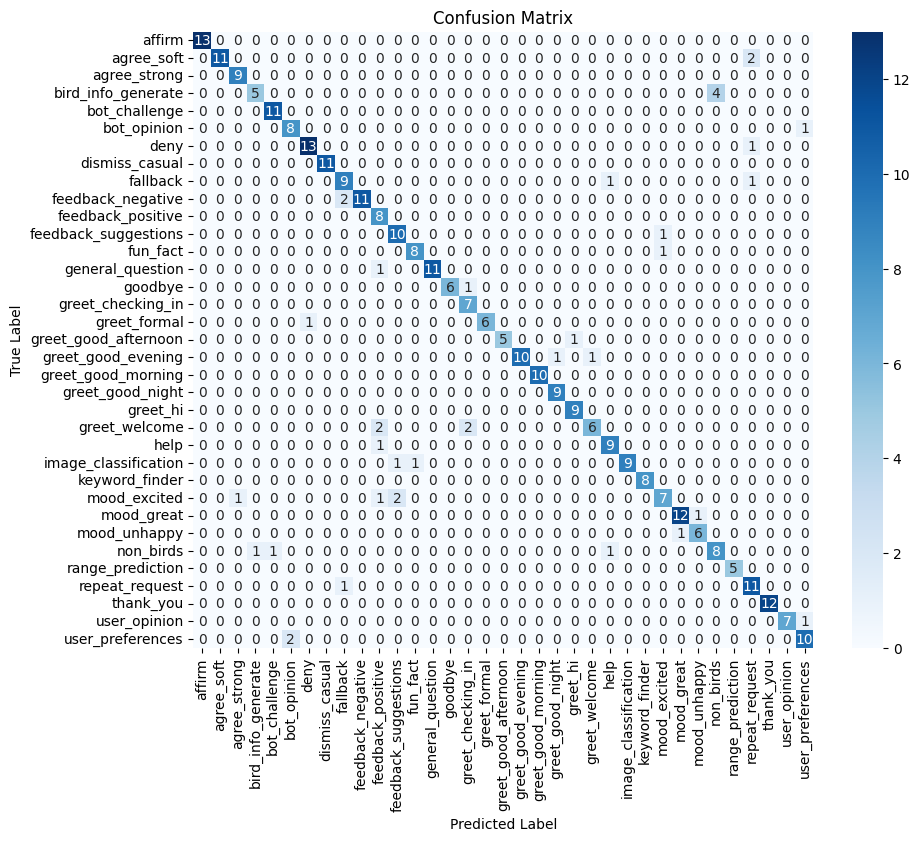

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get Predictions
y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

conf_mat = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


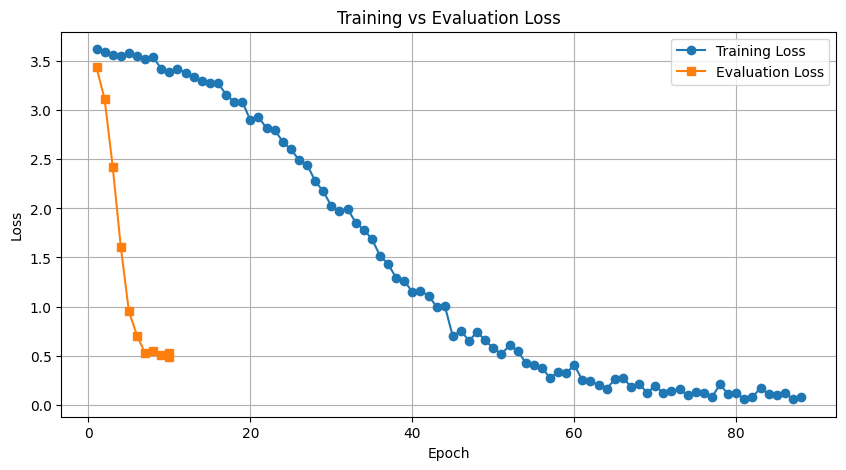

In [62]:
# Extract training and evaluation loss history
train_losses = []
eval_losses = []
epochs = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        epochs.append(log["epoch"])

# Plot Training vs. Evaluation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(epochs, eval_losses, label="Evaluation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid()
plt.show()

In [65]:
# Define save path
model_save_path = "/content/drive/MyDrive/DSGP/models/BERT_model_3"

# Save the trained model
trainer.save_model(model_save_path)

# Save the tokenizer (needed for inference)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/DSGP/models/BERT_model_3
